In [3]:
import pandas as pd
import numpy as np
from math import floor
import matplotlib.pyplot  as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

torch.manual_seed(42)

# Visualize training history
from keras.models import Sequential
from keras.layers import Dense

### Model Creation

In [4]:
# Choose CPU or Cuda device (If capable GPU present).
device = 'cpu'

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(50, 25) # hidden layer
        self.hidden2 = torch.nn.Linear(25, 25) # hidden layer
        self.out = torch.nn.Linear(25, 1)      # output layer

    def forward(self, x):
        z = F.relu(self.hidden1(x)) # activation function for first hidden layer
        z = F.relu(self.hidden2(z)) # activation function for second hidden layer
        z = self.out(z)        # linear output
        return z

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (hidden1): Linear(in_features=50, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=25, bias=True)
  (out): Linear(in_features=25, out_features=1, bias=True)
)


### Dataset Loading

In [5]:
dataset = pd.read_csv("Data/BTC-USD.csv")
print(dataset.shape)
dataset.head()

(1827, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


#### Scaling Dataset

In [6]:
scaled_data = dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler(copy=False)
scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(scaled_data[['Open', 'High', 'Low', 'Close', 'Volume']])
X = scaled_data['Close']
X

C:\Users\Μαρίνα Σαμ\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


0       0.000846
1       0.001299
2       0.002159
3       0.001813
4       0.001773
          ...   
1822    0.680117
1823    0.689799
1824    0.687676
1825    0.690270
1826    0.715508
Name: Close, Length: 1827, dtype: float64

In [7]:
class TimeSeriesDataset(Data.Dataset):   
    def __init__(self, data, window):
        self.data = torch.Tensor(data.values)
        self.window = window
    
    def __getitem__(self, index):
        return (self.data[index:index+self.window], self.data[index+self.window])
    
    def __len__(self):
        return self.data.__len__() - (self.window)

#### Data Preperation

In [8]:
split_ratio = 0.8
train_size = floor(X.size*split_ratio)
test_size = floor(X.size*(1-split_ratio))

train_dataset = TimeSeriesDataset(X[:train_size], 50)
test_dataset = TimeSeriesDataset(X[train_size:], 50)
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss() 

#### Training Function

In [9]:
def train(dataset, model, loss_fn, optimizer):
    size = len(dataset)
    model.train()
    for batch, (X, y) in enumerate(dataset):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X).squeeze(-1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  Batch: [{current:>5d}/{size:>5d}]")

#### Testing Function

In [10]:
def test(dataset, model, loss_fn):
    size = len(dataset)
    num_batches = len(dataset) - 50
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataset:
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze(-1)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

#### Training

In [11]:
EPOCHS = 20

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataset, model, loss_fn, optimizer)
    test(test_dataset, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.033330  Batch: [    0/ 1411]
loss: 0.000547  Batch: [  100/ 1411]
loss: 0.000395  Batch: [  200/ 1411]
loss: 0.011511  Batch: [  300/ 1411]
loss: 0.001070  Batch: [  400/ 1411]
loss: 0.000552  Batch: [  500/ 1411]
loss: 0.000015  Batch: [  600/ 1411]
loss: 0.000136  Batch: [  700/ 1411]
loss: 0.000198  Batch: [  800/ 1411]
loss: 0.000001  Batch: [  900/ 1411]
loss: 0.000024  Batch: [ 1000/ 1411]
loss: 0.000548  Batch: [ 1100/ 1411]
loss: 0.000053  Batch: [ 1200/ 1411]
loss: 0.000292  Batch: [ 1300/ 1411]
loss: 0.001326  Batch: [ 1400/ 1411]
Test Error: 
 Avg loss: 0.273505 

Epoch 2
-------------------------------
loss: 0.055735  Batch: [    0/ 1411]
loss: 0.000039  Batch: [  100/ 1411]
loss: 0.000305  Batch: [  200/ 1411]
loss: 0.011182  Batch: [  300/ 1411]
loss: 0.001021  Batch: [  400/ 1411]
loss: 0.000535  Batch: [  500/ 1411]
loss: 0.000014  Batch: [  600/ 1411]
loss: 0.000128  Batch: [  700/ 1411]
loss: 0.000191  Batch: [  800/ 141

loss: 0.000354  Batch: [  400/ 1411]
loss: 0.000210  Batch: [  500/ 1411]
loss: 0.000001  Batch: [  600/ 1411]
loss: 0.000001  Batch: [  700/ 1411]
loss: 0.000080  Batch: [  800/ 1411]
loss: 0.000276  Batch: [  900/ 1411]
loss: 0.000118  Batch: [ 1000/ 1411]
loss: 0.000207  Batch: [ 1100/ 1411]
loss: 0.000000  Batch: [ 1200/ 1411]
loss: 0.000059  Batch: [ 1300/ 1411]
loss: 0.000026  Batch: [ 1400/ 1411]
Test Error: 
 Avg loss: 0.094045 

Epoch 15
-------------------------------
loss: 0.013770  Batch: [    0/ 1411]
loss: 0.000005  Batch: [  100/ 1411]
loss: 0.000101  Batch: [  200/ 1411]
loss: 0.005400  Batch: [  300/ 1411]
loss: 0.000326  Batch: [  400/ 1411]
loss: 0.000192  Batch: [  500/ 1411]
loss: 0.000001  Batch: [  600/ 1411]
loss: 0.000003  Batch: [  700/ 1411]
loss: 0.000070  Batch: [  800/ 1411]
loss: 0.000299  Batch: [  900/ 1411]
loss: 0.000124  Batch: [ 1000/ 1411]
loss: 0.000186  Batch: [ 1100/ 1411]
loss: 0.000002  Batch: [ 1200/ 1411]
loss: 0.000053  Batch: [ 1300/ 1411]

#### Final Prediction

In [12]:
model.eval()
data = dataset['Close']
data = torch.Tensor(data[-50:].values)
output = model(data)
print(f'Predicted next-day price based on 50 previous ones: {output.item()}')

Predicted next-day price based on 50 previous ones: 28399.970703125


### Plotting

TypeError: plot got an unexpected keyword argument 'x'

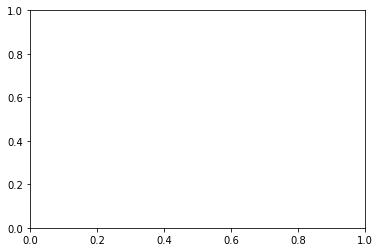

In [18]:

plt.plot(x= 'EPOCHS', y="trainlosses",
 color="green", alpha=0.8, legend="Train loss", line_width=2)
plt.plot(x= "EPOCHS", y="vallosses",
 color="red", alpha=0.8, legend="Val loss", line_width=2)